## Feature Imputation and BorutaShap Feature Selection
- Feature imputation by random forest, followed by model score testing (ran from scoring folder)
- Best model training data scores then used when running BorutaShap feature selection

In [16]:
import re

import numpy as np
import pandas as pd
from numpy import sort
from scipy.cluster import hierarchy
from scipy.stats import spearmanr

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

import seaborn as sns
import shap
import statsmodels.api as sm
import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

%matplotlib inline
%config InlineBackend.figure_format ='retina'
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

import statsmodels.stats.api as sms
import xgboost
from BorutaShap import BorutaShap
from missingpy import MissForest
from sklearn.ensemble import (
    BaggingRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
    StackingRegressor,
    VotingRegressor,
)

sns.set_style("darkgrid")
sns.mpl.rcParams["figure.figsize"] = (15.0, 9.0)

import warnings

import matplotlib
import matplotlib.pyplot as plt

warnings.simplefilter(action="ignore", category=FutureWarning)
from warnings import filterwarnings

filterwarnings("ignore")

seed = 0

In [2]:
data = pd.read_csv("training_cleaned.csv", header=0, sep=",")

In [3]:
data["BPlabel_encoded"] = data["BPlabel"].map(
    {"most likely": 1, "probable": 2, "least likely": 3}
)
Y = data["BPlabel_encoded"]
data = data.drop(["BPlabel"], 1)
data.shape

(293, 22)

### MissForest Imputation:

In [4]:
df1 = data.iloc[:, 0:21]
df = df1.set_index("Gene")

In [5]:
imputer = MissForest(random_state=seed)
X = pd.DataFrame(imputer.fit_transform(df), index=df.index, columns=df.columns)

Iteration: 0
Iteration: 1
Iteration: 2


In [9]:
#X.to_csv(r"2021-11-19_imputed_training_data.csv", index=False)

In [6]:
X = X.drop(['Brain - Amygdala_GTExTPM',
 'Kidney - Cortex_GTExTPM',
 'Liver_GTExTPM',
 'Adrenal Gland_GTExTPM',
 'Testis_GTExTPM'], 1, errors='ignore')

### BorutaShap Feature Selection:

In [15]:
# Best model and parameters measured on performance with all features to be used in BorutaShap

xgbr = xgboost.XGBClassifier(
    n_estimators=50,
    learning_rate= 0.2,
    max_depth=4,
    reg_alpha=1,
    reg_lambda=10,
    random_state=seed,
    eval_metric='mlogloss'
)


Feature_Selector = BorutaShap(
    model=xgbr, importance_measure="shap", classification=True
)

Feature_Selector.fit(X=X, y=Y, n_trials=100, random_state=seed)

100%|██████████| 100/100 [00:17<00:00,  5.64it/s]

6 attributes confirmed important: ['HIPred', 'Heart - Atrial Appendage_GTExTPM', 'Pituitary_GTExTPM', 'mousescore_Exomiser', 'SDI', 'pLI_ExAC']
7 attributes confirmed unimportant: ['betamax', 'humanscore_Exomiser', 'fishscore_Exomiser', 'GDI_Score', 'IPA_Activity', 'wgEncodeBroadHmmHuvecHMM.count', 'IPA_BP_annotation']
2 tentative attributes remains: ['Fallopian Tube_GTExTPM', 'Cells - EBV-transformed lymphocytes_GTExTPM']


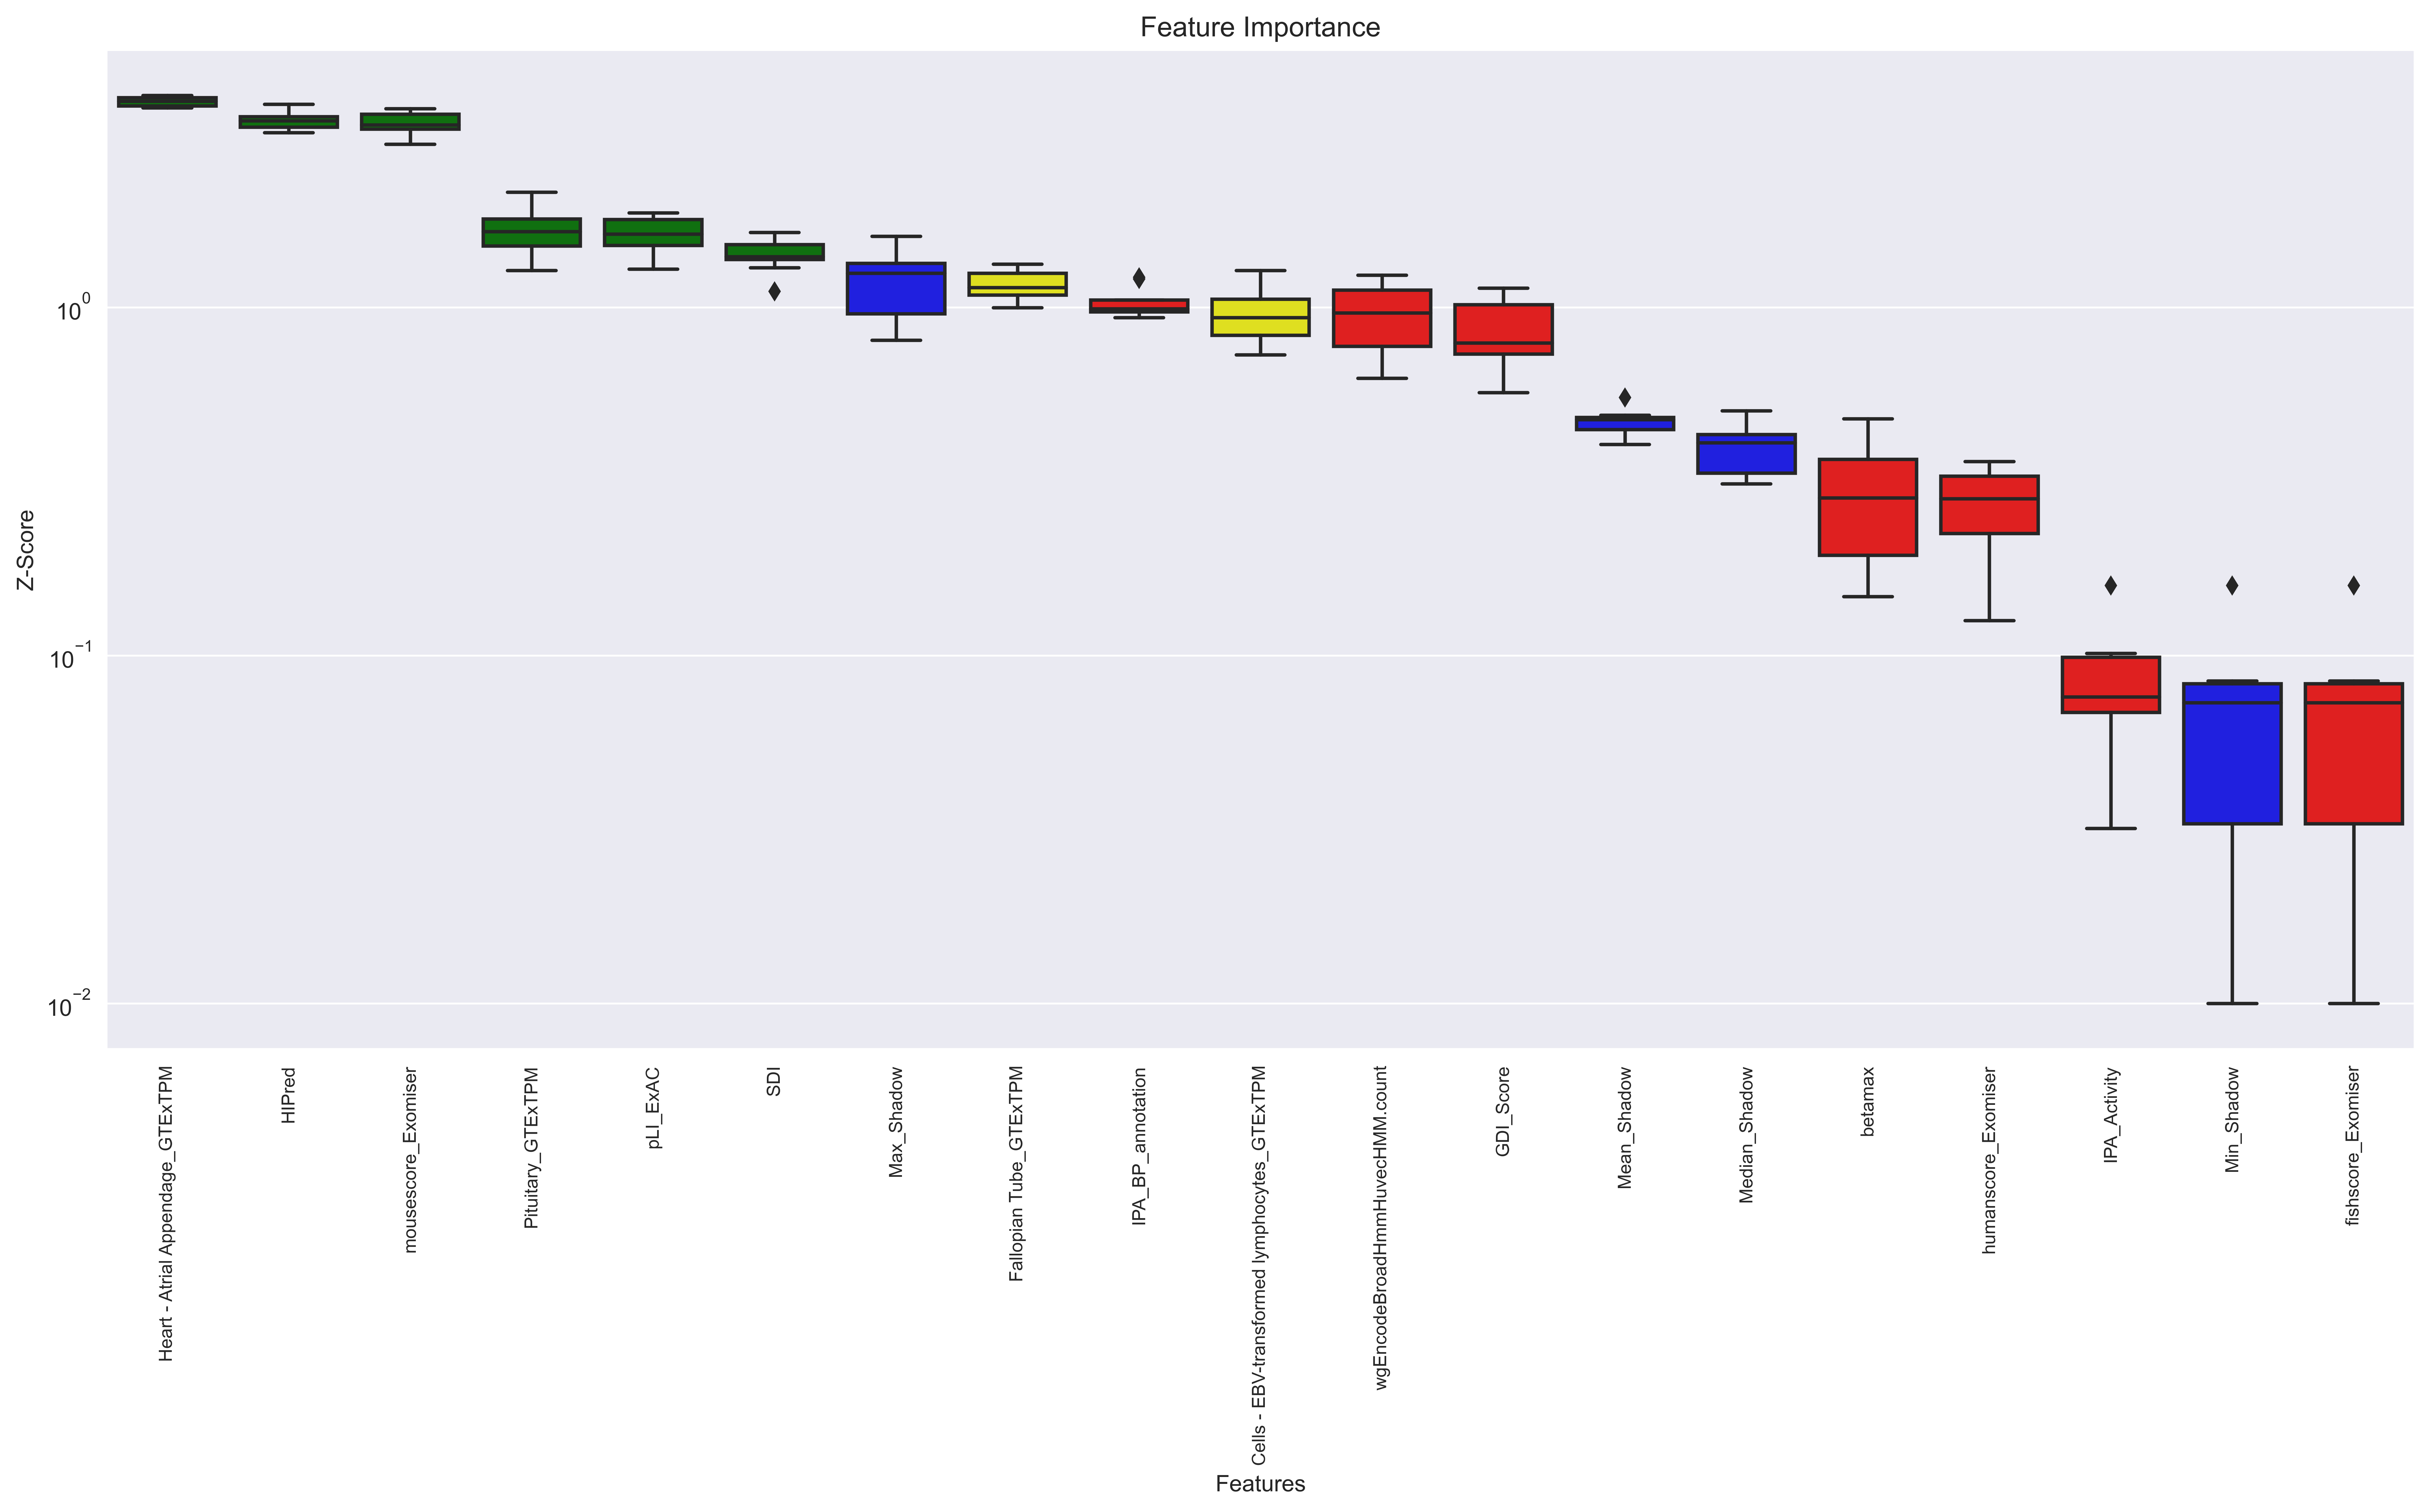

In [17]:
Feature_Selector.plot(which_features="all", X_rotation=90, figsize=(18,8))

In [18]:
Feature_Selector.TentativeRoughFix()

0 tentative features are now accepted: []
2 tentative features are now rejected: ['Fallopian Tube_GTExTPM' 'Cells - EBV-transformed lymphocytes_GTExTPM']


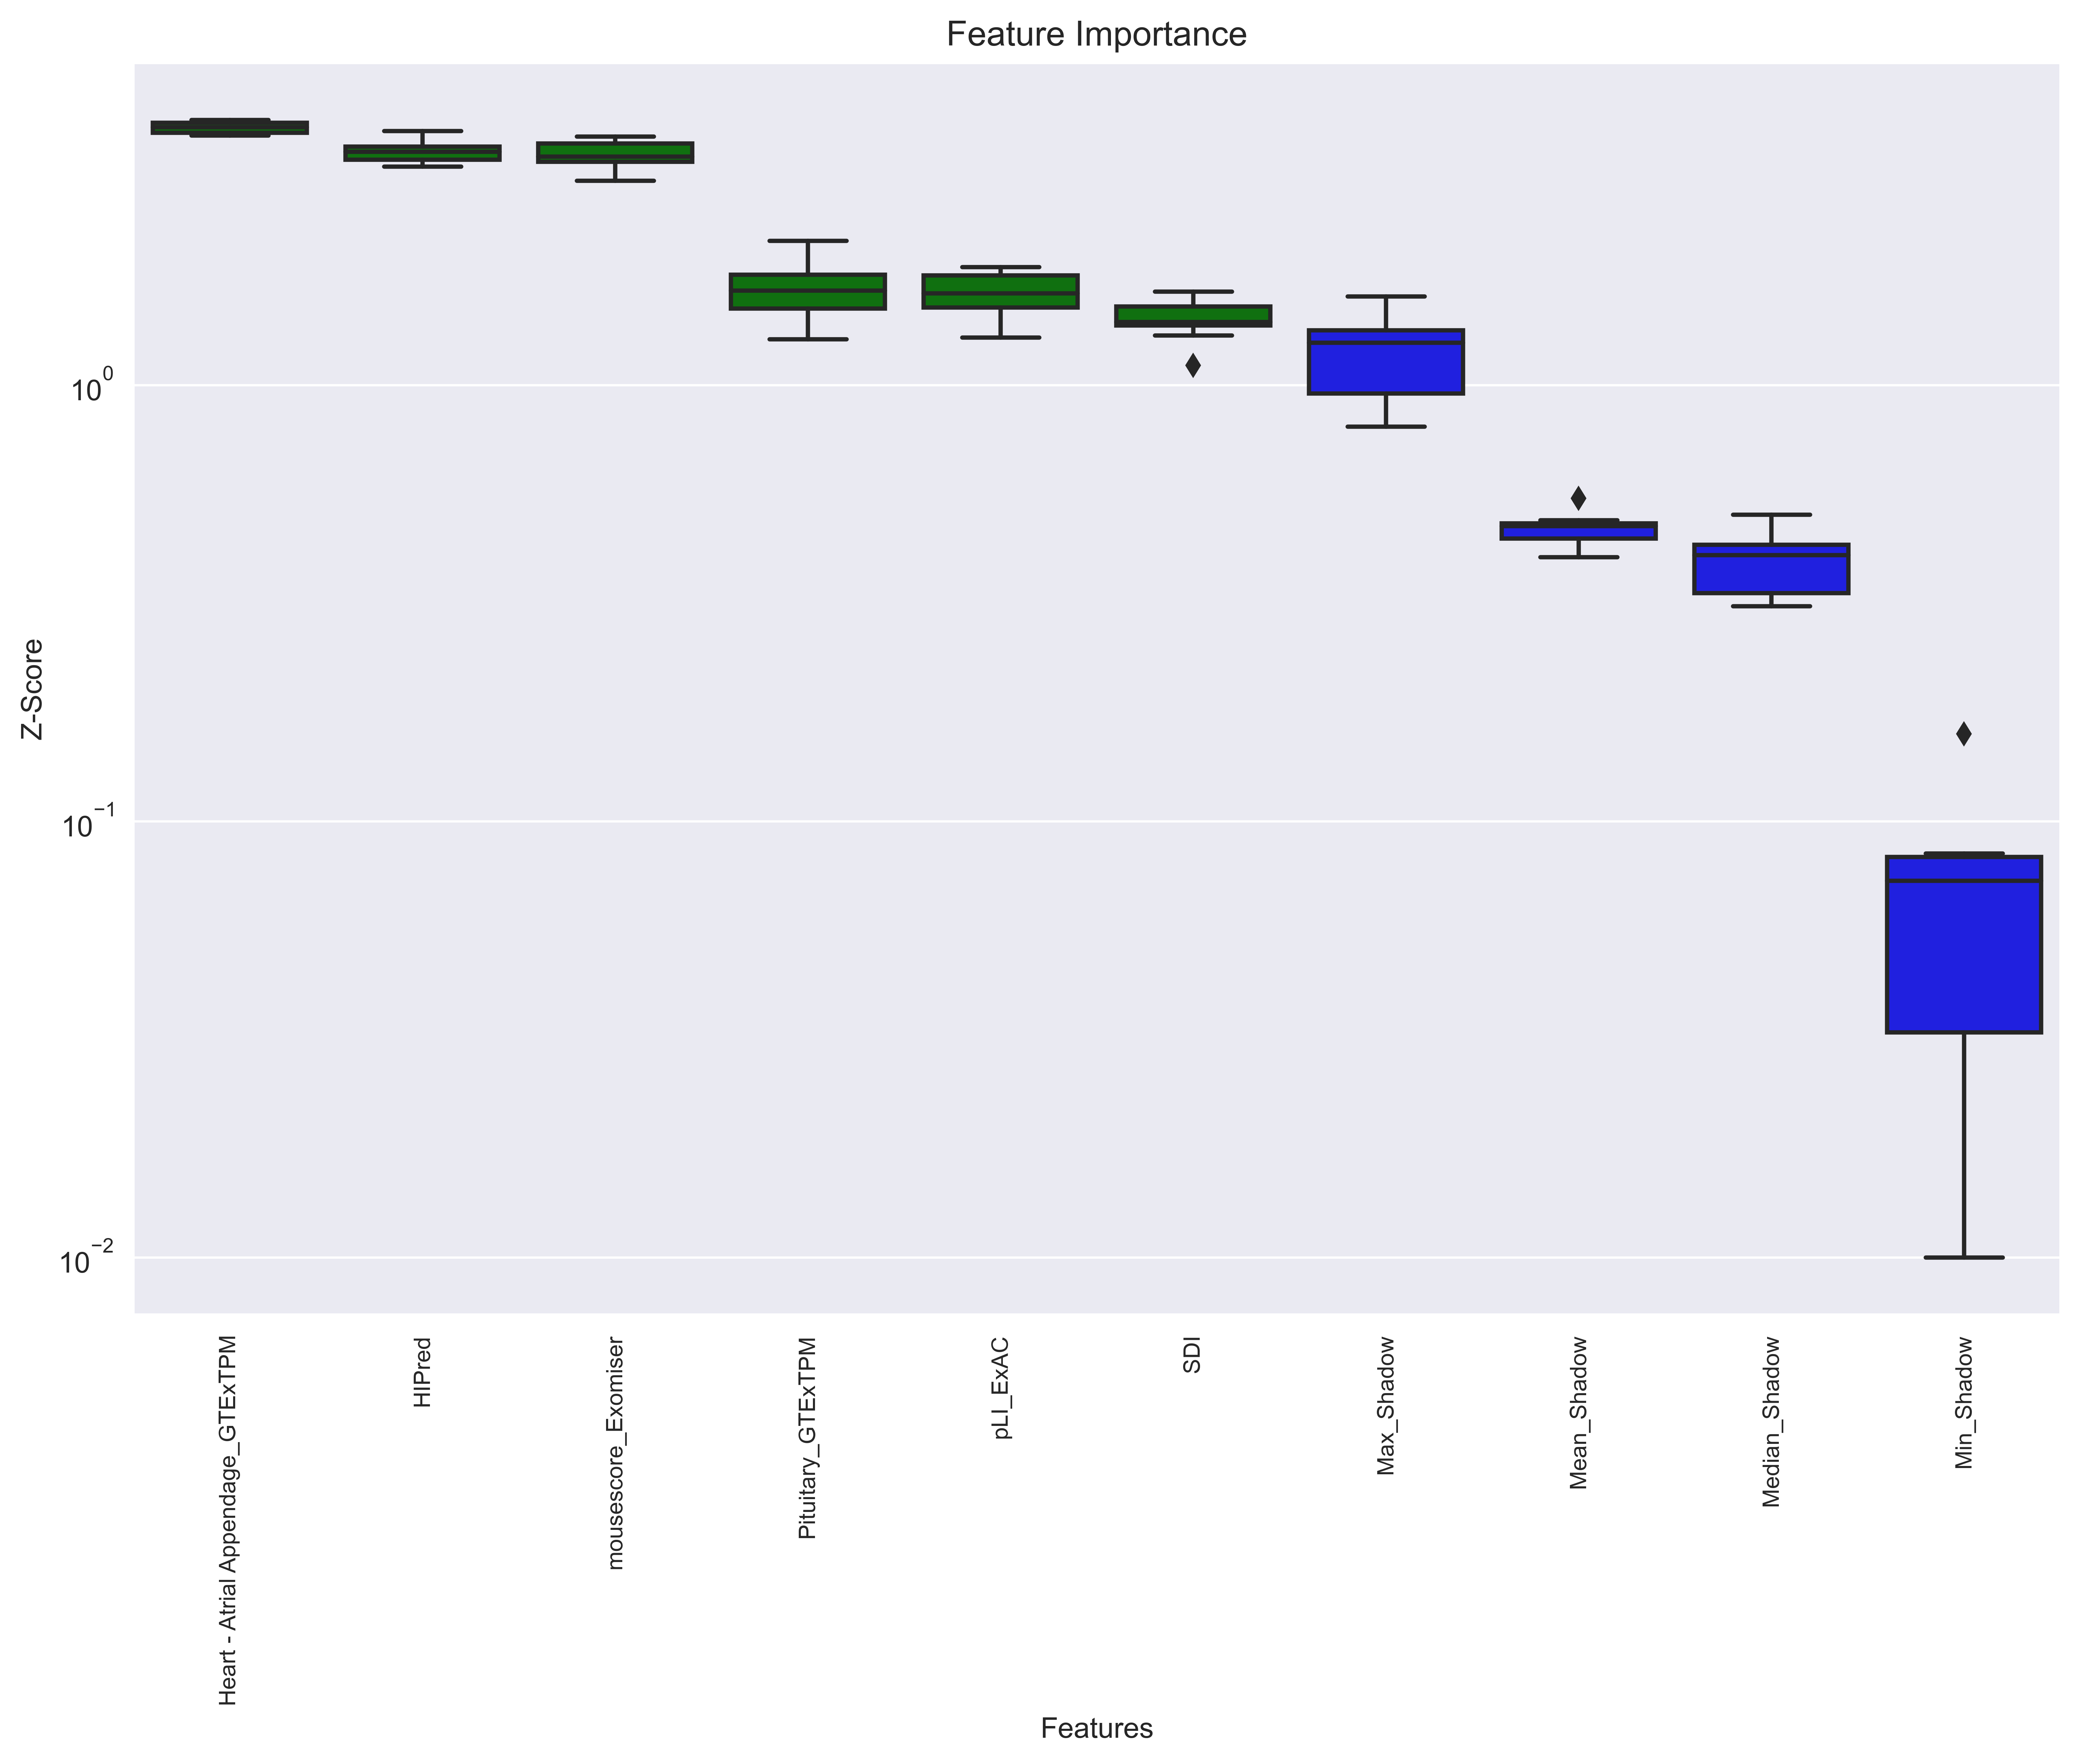

In [19]:
Feature_Selector.plot(which_features="accepted")

In [20]:
subset = Feature_Selector.Subset()

# Selected features:
X_boruta_sel = subset

X_boruta_sel.shape

(293, 6)

In [14]:
X_boruta_sel.to_csv(r"selected_features_training_data.csv", index=False)